# Análisis sobre peliculas

### Práctica realizada por Óscar Calvet Sisó y Javier Alarcón Caracena

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies =pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.450498e+07,2.500010e+07
mean,8.118928e+04,2.136623e+04,3.533583e+00,1.215601e+09
std,4.679172e+04,3.918468e+04,1.063796e+00,2.268758e+08
min,1.000000e+00,0.000000e+00,-5.000000e+00,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.944000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.622000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,1.000000e+01,1.574328e+09


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Control de duplicados

Para comenzar vamos a asumir que los usuarios únicamente pueden evaluar una película una única vez. Por ello tomamos la combinación de userId y movieId como un identificador único y comprobamos si existen duplicados basados en estas características.

In [5]:
ratings[ratings.duplicated(subset = ['userId','movieId'])].describe()

,userId,movieId,rating,timestamp
count,5055.000000,5055.0,4973.000000,5.055000e+03
mean,80820.345203,0.0,3.338428,1.262703e+09
std,45919.620290,0.0,1.071548,2.104337e+08
min,23.000000,0.0,-1.500000,8.282482e+08
25%,41601.500000,0.0,3.000000,1.092242e+09
50%,79689.000000,0.0,3.500000,1.257199e+09
75%,119566.000000,0.0,4.000000,1.466536e+09
max,162519.000000,0.0,5.000000,1.574216e+09


En el caso del conjunto de ratings podemos ver que existen 158.910 reseñas posiblemente duplicadas, además es notable que todas estas ocurren únicamente en la película con id igual a cero, vamos a ver a qué película corresponden estas reseñas:

In [6]:
movies[movies['movieId'] == 0]

,movieId,title,genres


Vemos que no corresponde a ninguna película que conozcamos. Esto junto al hecho de que este id contiene valores atípicos (hay ratings por debajo de cero y por encima de diez) junto a que no poseemos información sobre la película (lo cual nos incapacita el uso de estas entradas) nos lleva a no solo eliminar los duplicados si no a eliminar también las entradas con movieId igual a cero en el dataframe de ratings. Esta decisión también está motivada por la existencia de valores atípicos dentro de este subconjunto, podemos observar valoraciones fuera del intervalo $[0,5]$.

In [10]:
ratings.drop(ratings[ratings['movieId'] == 0].index, inplace = True)

Resumimos las esdísticas de estos valores duplicados eliminados

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    25000095   |      24983      |    0,0999%    |

Pasamos a analizar el conjunto de duplicados presentes en la base de datos de las películas. En este caso asumimos que el identificador único es el id de la película.

In [12]:
movies[movies.duplicated(subset = ['movieId'])].describe()

,movieId
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


En este caso no hay duplicados en base al id. Como el título también debería ser único para cada película ya que asumimos que es extraño que se publiquen dos películas diferentes en el mismo año y con el mismo título, vamos a comprobar que no haya dos películas con el mismo título e identificador diferente.

In [13]:
movies[movies.duplicated(subset = ['title'], keep = False)].sort_values('title')

,movieId,title,genres
61103,204982,9 (2009),Comedy
13713,71057,9 (2009),Adventure|Animation|Sci-Fi
37060,151797,Absolution (2015),Drama|Thriller
30628,136696,Absolution (2015),Action|Adventure|Crime|Thriller
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
...,...,...,...
49443,178895,Veronica (2017),Drama|Mystery|Thriller
12909,64997,War of the Worlds (2005),Action|Sci-Fi
10055,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
17391,91199,Weekend (2011),Drama|Romance


En este caso sí que hemos encontrado películas con el mismo título y año de publicación que además pertenecen a géneros distintos. Vamos a comprobar por ejemplo si en 2009 se publicaron dos películas tituladas "9" y observamos que no es el caso. Veamos si tenemos reviews para los dos identificadores para la película "9":

In [14]:
print(f"Hay {len(ratings[ratings['movieId']==204982])} reviews para el primer id")
print(f"Hay {len(ratings[ratings['movieId']==71057])} reviews para el segundo id")

Hay 1 reviews para el primer id
Hay 3283 reviews para el segundo id


Concluimos entonces que algunas películas figuran dos veces en el conjunto de movies y que son referenciadas mediante identificadores disitintos. Para solventar este problema debemos unificar los id y además también vamos a agregar los géneros de cada entrada. Primero unificamos los id:

In [15]:
#Generamos diccionarios para unificar los id
titles = {}
translate_id = {}
for row in movies[movies.duplicated(subset = ['title'], keep = False)].index:
    title = movies['title'][row]
    movieid = movies['movieId'][row]
    if title in titles:
        translate_id[movieid] = titles[title]
    else:
        titles[title]=movieid

In [17]:
ratings.loc[ratings['movieId'].isin(translate_id), 'movieId']=ratings.loc[ratings['movieId'].isin(translate_id), 'movieId'].apply(lambda x : translate_id[x])

Unificamos códigos en movies:

In [19]:
movies.loc[movies['movieId'].isin(translate_id), 'movieId']=movies.loc[movies['movieId'].isin(translate_id), 'movieId'].apply(lambda x : translate_id[x])

Agregamos géneros:

In [20]:
movies = movies.groupby(['movieId', 'title'], as_index = False).agg('|'.join)

Mostramos las estadísticas de las filas modificadas en cada conjunto:

|         | Nº de partida | Nº de modificados | % modificados |
|:-------:|:-------------:|:-----------------:|:-------------:|
| ratings |    24975112   |        1635       |     0,006%    |
|  movies |     62423     |        98        |     0,157%    |

Finalmente, para el análisis a realizar no podemos utilizar reviews de películas que no figuren en la base de datos de movies. Por ello eliminamos todas las reviews cuyo id no se encuentra en movies.

In [23]:
valid_id = movies['movieId'].unique()
ratings.drop(ratings[~ratings['movieId'].isin(valid_id)].index, inplace = True)

Después de ejecutar este comando, vemos que hay al menos una review para todas las películas.

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:-----------------:|:-------------:|
| ratings |    24975112   |         0         |       0%       |

In [24]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.497511e+07,2.497511e+07,2.448050e+07,2.497511e+07
mean,8.118922e+04,2.138401e+04,3.533589e+00,1.215600e+09
std,4.679195e+04,3.919295e+04,1.063786e+00,2.268755e+08
min,1.000000e+00,1.000000e+00,-5.000000e+00,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,1.000000e+01,1.574328e+09


## Valores atípicos

En las columnas de userId y movieId no haremos un estudio, ya que los datos son enteros, lo que concuerda con la propia definición de Id, faltaría comprobar que todos los ratings se encuentran entre 0 y 5 y comprobar que timbestamp está en las fechas correctas.

### Timestamp

In [25]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Comenzaremos estudiando el timestamp.

In [26]:
inicio =pd.Timestamp(1995,1,9).timestamp()
fin = pd.Timestamp(2019,11, 21).timestamp()
outliers_time = ratings[(ratings['timestamp'] > fin) | (ratings['timestamp'] < inicio)]

In [27]:
np.max(outliers_time['timestamp']-fin)/(3600)

9.250833333333333

Respecto a los outliers de timestamp, podemos observar que solamente sobrepasan la fecha límite en un máximo de 9h, esta diferencia puede deberse a los distinto husos horarios en el mundo, por lo que no los podemos considerar outliers.

### Ratings

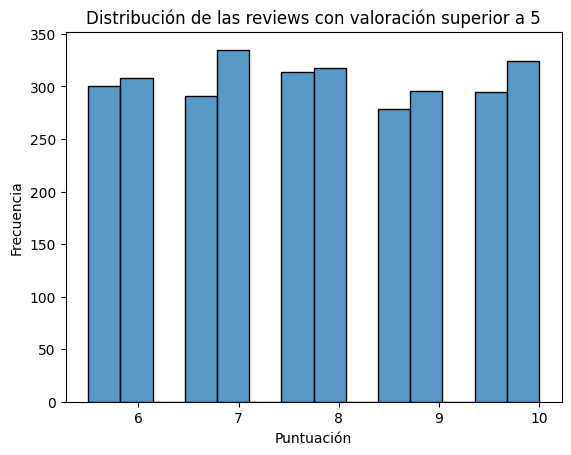

In [28]:
outliers_rating = ratings[(ratings['rating']>5)]
b = sns.histplot(data=outliers_rating['rating'])
b.set(title='Distribución de las reviews con valoración superior a 5', xlabel = 'Puntuación', ylabel = 'Frecuencia');

Podemos ver que todos los outliers mayores que 5 siempre son menores que 10, esto nos presenta con dos problemáticas, la primera: es que es posible que estos datos se encuentren en escala de 0 a 10; el segundo es que es posible que existan valoraciones en escala de 0 a 10 que no hemos podido detectar. Si observamos ahora los valores negativos obtenemos:

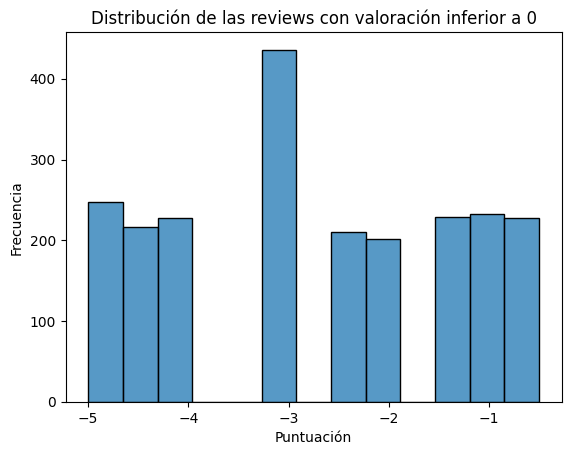

In [29]:
outliers_rating_d = ratings[(ratings['rating']<0)]
b = sns.histplot(data=outliers_rating_d['rating'])
b.set(title='Distribución de las reviews con valoración inferior a 0', xlabel = 'Puntuación', ylabel = 'Frecuencia');

Podemos observar que todos son mayores que $-5$ lo cuál también nos lleva a suponer que estos valores son los originales pero cambiados de signo. Dado que modificar estos valores acarrea un alto grado de suposiciones que no podemos confirmar, decidimos que lo más apropiado es eliminar estas reviews.

In [30]:
print(len(ratings))

24975112


In [31]:
ratings.drop(ratings[(ratings['rating']<0)].index, inplace = True)
ratings.drop(ratings[(ratings['rating']>5)].index, inplace = True)

In [32]:
print(len(ratings))

24969825


In [33]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.496982e+07,2.496982e+07,2.447521e+07,2.496982e+07
mean,8.118940e+04,2.138412e+04,3.533630e+00,1.215600e+09
std,4.679203e+04,3.919311e+04,1.060974e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


En la siguiente tabla resumimos los valores eliminados:

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    24975112   |      5287      |    0,021%    |

## Tratamiento de datos perdidos

Podemos ver claramente que en la columna ratings faltan valores.

Tanto por uno de valores perdidos: 0.019808548918544683


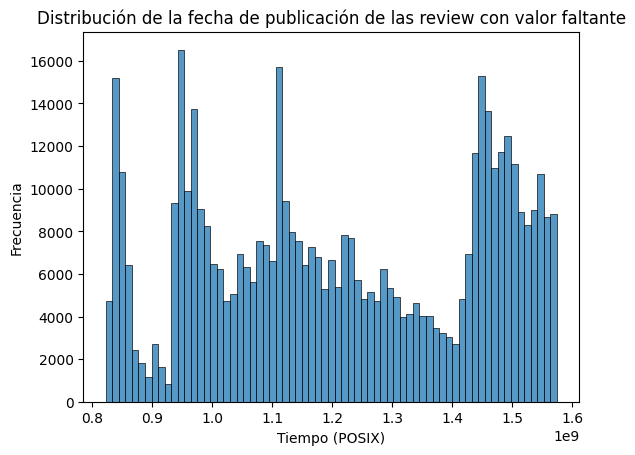

In [34]:
indexna = ratings['rating'].isna()
print(f'Tanto por uno de valores perdidos: {sum(indexna)/len(ratings)}')

b = sns.histplot(data=ratings[indexna]['timestamp'])
b.set(title='Distribución de la fecha de publicación de las review con valor faltante', xlabel = 'Tiempo (POSIX)', ylabel = 'Frecuencia');

Parece que la fecha en la que se ha publicado la review no influye en la pérdida de la valoración.

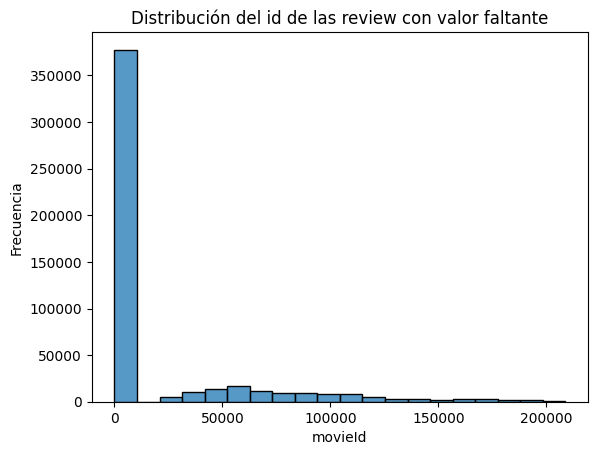

In [35]:
b = sns.histplot(data=ratings[indexna]['movieId'], bins = 20)
b.set(title='Distribución del id de las review con valor faltante', xlabel = 'movieId', ylabel = 'Frecuencia');

Podemos observar que la mayoría de las películas donde se ha perdido la valoración tiene un Id bajo. Esto nos lleva a analizar si al eliminar estos registros estaremos eliminando toda la información sobre una película.

In [42]:
sum_perdidos_id = ratings['rating'].isna().groupby(ratings['movieId']).sum()
total_id = ratings['rating'].groupby(ratings['movieId'], dropna= False).size()
total_id.describe()

count    58939.000000
mean       423.655389
std       2477.151184
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81406.000000
Name: rating, dtype: float64

count    58939.000000
mean         0.020067
std          0.079362
min          0.000000
25%          0.000000
50%          0.000000
75%          0.017073
max          1.000000
Name: rating, dtype: float64
220


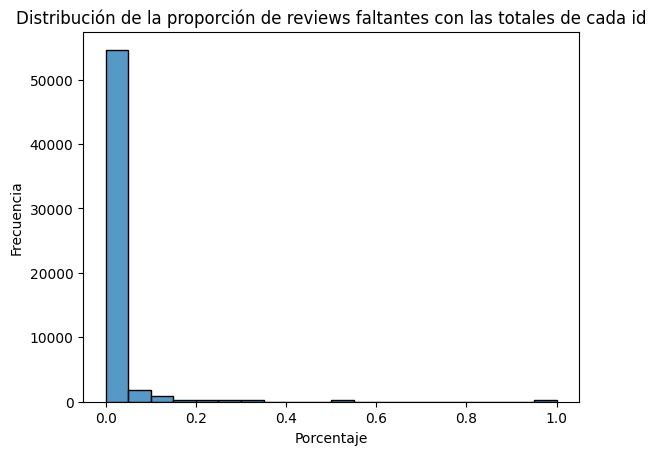

In [43]:
frecuencia_id = sum_perdidos_id/total_id
print(frecuencia_id.describe())
b = sns.histplot(data=frecuencia_id, bins = 20)
b.set(title='Distribución de la proporción de reviews faltantes con las totales de cada id', xlabel = 'Porcentaje', ylabel = 'Frecuencia');
print(len(frecuencia_id[frecuencia_id>0.5]))

En la mayoría de los casos la proporción es cercana a cero. Podemos observar que hay 220 películas de las cuales más de la mitad de las reviews se han perdidos los ratings.

In [44]:
print(len(frecuencia_id[frecuencia_id==1.0]))

215


De esas 220, 215 no tienen ninguna review. Por tanto, aquellas películas con todas las reviews faltantes las eliminaremos de ambos data sets y aquellas que tengan alguna valoración trabajaremos con ellas: 
- Si tienen más del 50% de reviews faltantes eliminaremos esos registros.
- En caso contrario completaremos con la media de esa película.


Eliminamos aquellas películas donde todas sus reviews carecen de valoración.

In [50]:
eliminar = frecuencia_id[frecuencia_id==1.0].index
ratings = ratings[~ratings['movieId'].isin(eliminar)]
movies = movies[~movies['movieId'].isin(eliminar)]

En la siguiente tabla podemos ver las estadísticas de los eliminados.

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    24969825   |        217       |    0,0008%   |
|  movies |     62325     |        215       |    0,345%    |

Eliminamos las reviews de las películas donde el 50% o más estas no poseen una valoración.

In [53]:
eliminar_na = frecuencia_id[(frecuencia_id>=0.5) & (frecuencia_id<1.0)].index
ratings = ratings[~((ratings['movieId'].isin(eliminar_na)) & (ratings['rating'].isna()))]

En la siguiente tabla queda resumida la operación de eliminación:

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    24969608   |        334       |    0,001%    |

Calculamos la media para cada película a la que no le falten más de la mitad de las valoraciones y después sustituimos los valores faltantes por esta.

In [54]:
index_media = frecuencia_id[(frecuencia_id<0.5) & (frecuencia_id>0.0)].index
medias = ratings[ratings['movieId'].isin(index_media)].groupby(ratings['movieId'], as_index=False).mean()

Creamos un diccionario que relaciona el Id de la película con su media.

In [55]:
dict_means = {}
medias['movieId']=medias['movieId'].astype(int)
for row in medias.index:
    dict_means[medias['movieId'][row]] = medias['rating'][row]

Sustituimos por la media.

In [56]:
print(len(ratings))
print(len(ratings.loc[ratings['rating'].isna(), 'rating']))

24969274
494065


In [57]:
ratings.loc[ratings['rating'].isna(), 'rating']=ratings.loc[ratings['rating'].isna(), 'movieId'].apply(lambda x : dict_means[x])

Mostramos las estadísticas de los valores modificados:

|         | Nº de partida | Nº de modificados | % modificados |
|:-------:|:-------------:|:-----------------:|:-------------:|
| ratings |    24969274   |       494065      |     1,979%    |

Observamos si existen valores perdidos y vemos que no es el caso.

In [58]:
ratings[ratings['rating'].isna()]

,userId,movieId,rating,timestamp


In [59]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.496927e+07,2.496927e+07,2.496927e+07,2.496927e+07
mean,8.118954e+04,2.138105e+04,3.533628e+00,1.215594e+09
std,4.679216e+04,3.918780e+04,1.052394e+00,2.268739e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011745e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198866e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447202e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


### Valores atípico en movies

Pasamos a estudiar si hay algún valor atípicos en el segundo dataset. Primero vemos si hay alguna película sin título:

In [60]:
movies[movies['title']==""]

,movieId,title,genres


No es el caso, además por el trabajo anterior sabemos que todos los títulos son diferentes. Pasamos a ver si hay alguna película con el contenido de género vacío.

In [61]:
movies[movies['genres']==""]

,movieId,title,genres


Veamos todas las categorías:

In [62]:
movies['genres'].value_counts()

Drama                                                     9002
Comedy                                                    5644
(no genres listed)                                        5010
Documentary                                               4689
Comedy|Drama                                              2369
                                                          ... 
Animation|Children|Comedy|Fantasy|Musical|Romance|IMAX       1
Adventure|Crime|Drama|Horror|Thriller                        1
Film-Noir|Romance|Thriller                                   1
Adventure|Documentary|Western                                1
Comedy|Horror|Mystery|Sci-Fi|Western                         1
Name: genres, Length: 1741, dtype: int64

Observamos que aparece un valor extraño correspondiente a "(no genres listed)", esto indica que estas películas no están catalogadas en ningún género lo cual nos puede causar problemas.

In [63]:
movies[movies['genres'].str.contains("(no genres listed)")]['genres'].value_counts()

C:\Users\USER\AppData\Local\Temp\ipykernel_6764\3102738869.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies[movies['genres'].str.contains("(no genres listed)")]['genres'].value_counts()


(no genres listed)                                  5010
Drama|(no genres listed)                               2
(no genres listed)|Horror                              2
Horror|Thriller|(no genres listed)                     2
Drama|Romance|(no genres listed)                       1
Documentary|(no genres listed)                         1
Sci-Fi|(no genres listed)                              1
Comedy|(no genres listed)                              1
Comedy|Drama|(no genres listed)                        1
(no genres listed)|Documentary                         1
Fantasy|Sci-Fi|(no genres listed)                      1
(no genres listed)|Drama|Horror|Mystery|Thriller       1
(no genres listed)|Drama                               1
Name: genres, dtype: int64

Comprobamos que algunas películas repetidas no tenían género en algunas de sus entradas pero en el resto sí, para solucionar esto y quedarnos con los géneros reales creamos una función:

In [64]:
def remove_no_genres(x):
    if x == "(no genres listed)":
        return x
    if "(no genres listed)" in x:
        genres = re.split('\|', x)
        new_genre = ""
        for g in genres:
            if(g!= "(no genres listed)"):
                new_genre = new_genre + '|' + g
        return new_genre[1:]
    else:
        return x

Y la aplicamos al conjunto

In [66]:
movies['genres'] = movies['genres'].apply(remove_no_genres)

En total hemos modificado 15 registros:

|         | Nº de partida | Nº de modificados | % modificados |
|:-------:|:-------------:|:-----------------:|:-------------:|
|  movies |     62110     |         15        |     0,024%    |

Al unificar las películas con títulos duplicados es posible que hayamos repetido el género dos veces, para solucionar esto utilizamos otra función.

In [67]:
def remove_dup_genres(x):
    genres = set(re.split('\|', x))
    new_gen = ""
    for g in genres:
        new_gen = new_gen + '|' + g
    return new_gen[1:]

In [68]:
movies['genres']=movies['genres'].astype(str)

In [69]:
movies['genres'] = movies['genres'].apply(remove_dup_genres)

Ahora procedemos a observar el porcentaje de películas sin género y también el porcentaje de reviews a las que afecta.

In [70]:
index_no_gen = movies[movies['genres'] == '(no genres listed)']['movieId'].values
print(f"Nº de reviews de películas sin género: {len(ratings[ratings['movieId'].isin(index_no_gen)])}")
print(f"Proporción del total: {len(ratings[ratings['movieId'].isin(index_no_gen)])/len(ratings)}")

Nº de reviews de películas sin género: 26438
Proporción del total: 0.0010588213337720592


Como solo figuran en el 0,1% de las reviews totales, decidimos eliminar estas entradas tanto del conjunto de películas como del de reviews.

In [72]:
ratings.drop(ratings[ratings['movieId'].isin(index_no_gen)].index, inplace = True)
movies.drop(movies[movies['movieId'].isin(index_no_gen)].index, inplace = True)

Terminamos con estos valores:

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    24969274   |       26438      |    0,106%    |
|  movies |     62110     |       5010       |    8,066%    |

## Normalización de los datos

No vamos a normalizar ningún dato numérico del dataset ya que normalizar los id eliminaría su utilidad y tampoco los ratings ya que vamos a analizar y visualizar sus valores en el rango $[0,5]$ que es más comprensible que el normalizado.

Mostramos las diferencias entre los datasets originales y los transformados:

|         | Nº de partida | Nº de eliminados | % eliminados |
|:-------:|:-------------:|:----------------:|:------------:|
| ratings |    25000095   |      57259      |    0,229%    |
|  movies |     62423     |       5.323       |    8,527%    |

## Análisis

### Media de ratings por año y género

Para cada año de los que haya información, lista de géneros con la media de
puntuación para cada uno, ordenados de mayor a menos según esta media. Para realizar esta medición vamos a separar los géneros del conjunto de movies.

In [74]:
movies_exp = movies.assign(genres=movies.genres.str.split('|')).explode('genres')

In [75]:
movies_exp.head()

,movieId,title,genres
0,1,Toy Story (1995),Fantasy
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation


Ahora juntamos los dos datasets mediante el movieId:

In [76]:
comb = ratings.merge(movies_exp, on="movieId", how = "left")
comb.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Drama
1,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
2,1,296,5.0,1147880044,Pulp Fiction (1994),Crime
3,1,296,5.0,1147880044,Pulp Fiction (1994),Thriller
4,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama


Modificamos el timestamp para que muestre el año.

In [77]:
comb['timestamp'] = pd.DatetimeIndex(pd.to_datetime(comb['timestamp'],unit='s')).year
comb.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,2006,Pulp Fiction (1994),Drama
1,1,296,5.0,2006,Pulp Fiction (1994),Comedy
2,1,296,5.0,2006,Pulp Fiction (1994),Crime
3,1,296,5.0,2006,Pulp Fiction (1994),Thriller
4,1,306,3.5,2006,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama


Agrupamos por año y género y calculamos la media para cada combinación de clave-valor.

In [78]:
year_genre = comb.groupby(['timestamp', 'genres'], as_index=False)['rating'].mean().sort_values(by=['rating'], ascending=False)
year_genre = year_genre.sort_values(by = ['timestamp', 'rating'],ascending=[True, False])

Mostramos para cada año los valores

C:\Users\USER\AppData\Local\Temp\ipykernel_6764\2064692873.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
C:\Users\USER\AppData\Local\Temp\ipykernel_6764\2064692873.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
C:\Users\USER\AppData\Local\Temp\ipykernel_6764\2064692873.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
C:\Users\USER\AppData\Local\Temp\ipykernel_6764\2064692873.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)
C:\Users\USE

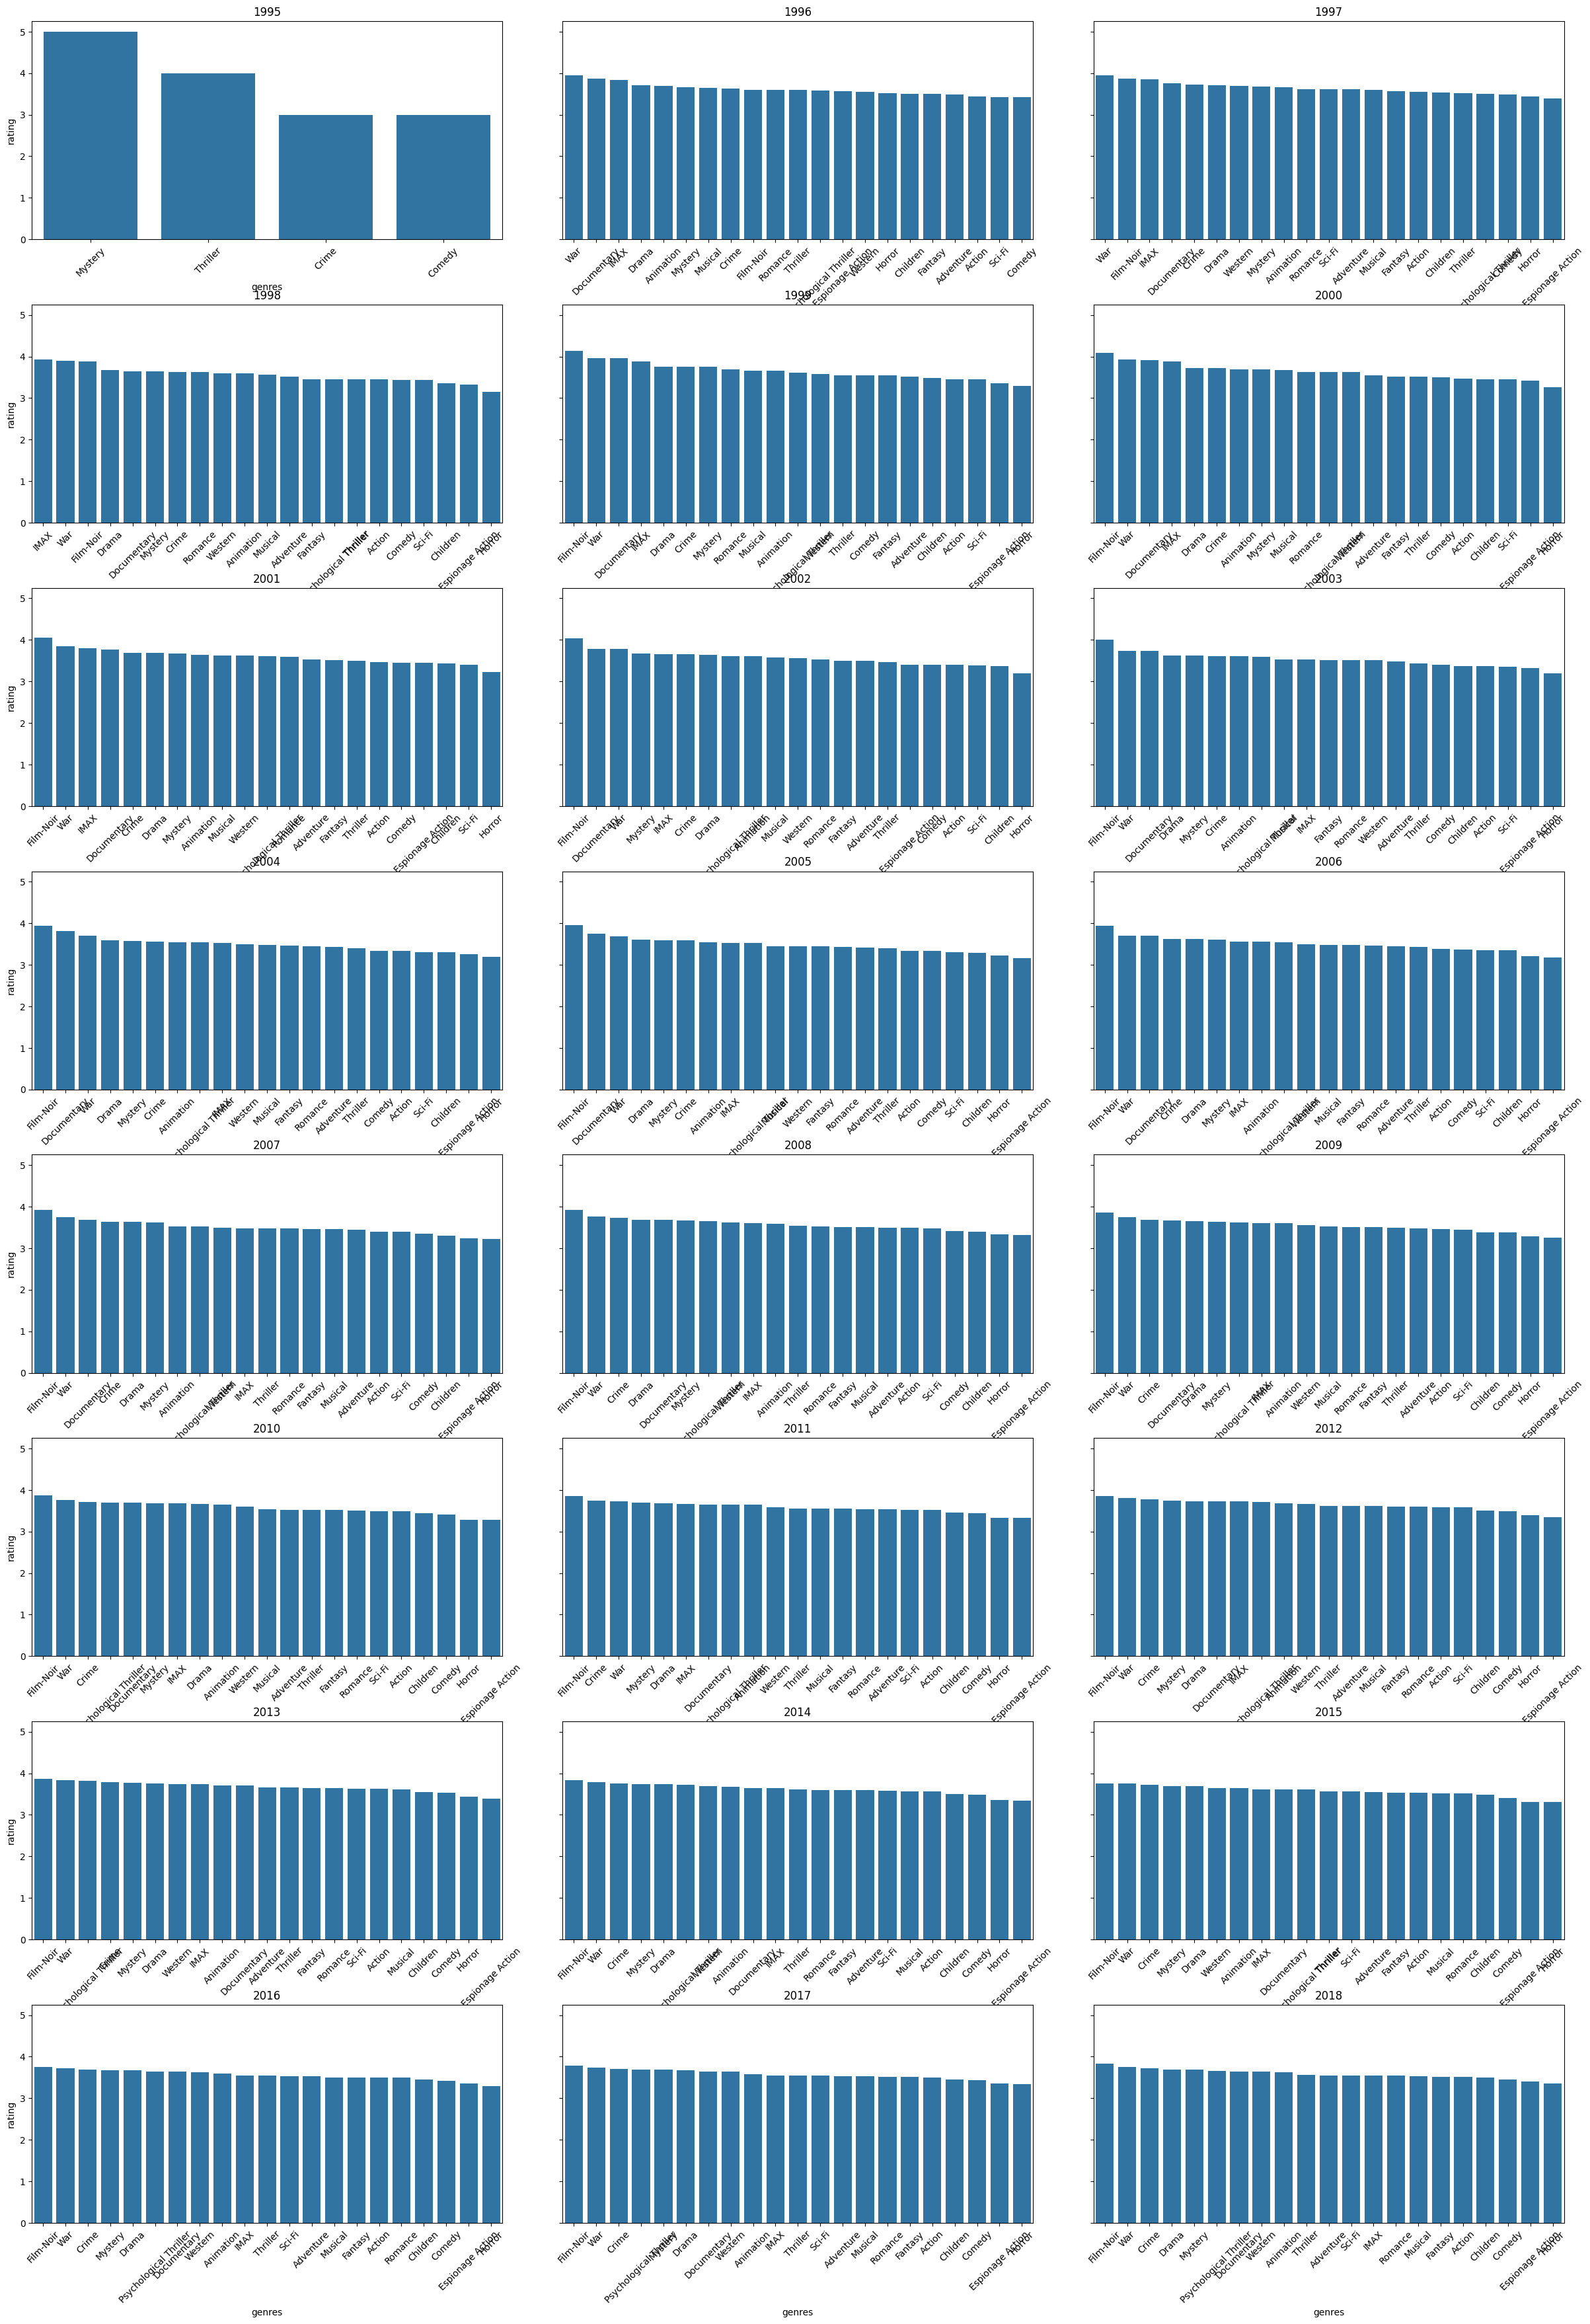

In [79]:
fig, axs = plt.subplots(8, 3, figsize=(25,35), sharey = True)
fig.tight_layout(pad = 5.0)
for i in range(8):
    for j in range(3):
        g = sns.barplot(data=year_genre[year_genre['timestamp'] == 1995+3*i+j], x = 'genres', y ='rating', ax=axs[i][j])
        g.set_xticklabels(g.get_xticklabels(), rotation=45)
        g.set(title = str(1995+3*i+j))

Presentamos la tabla con los resultados:

In [80]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(year_genre.sort_values(by = ['timestamp', 'rating'],ascending=[True, False]).set_index(['timestamp', 'genres']))

                                  rating
timestamp genres                        
1995      Mystery                  5.000
          Thriller                 4.000
          Crime                    3.000
          Comedy                   3.000
1996      War                      3.955
          Documentary              3.864
          IMAX                     3.844
          Drama                    3.702
          Animation                3.693
          Mystery                  3.661
          Musical                  3.649
          Crime                    3.622
          Film-Noir                3.602
          Romance                  3.601
          Thriller                 3.596
          Psychological Thriller   3.583
          Espionage Action         3.560
          Western                  3.546
          Horror                   3.523
          Children                 3.503
          Fantasy                  3.497
          Adventure                3.481
          Action

Cabe destacar que estas medias pueden contener sesgos debido a la presencia de reviews de hasta puntuación 10, las cuales podrían indicar la existencia de valoraciones entre 0 y 10 en nuestros datos que no hemos podido eliminar. Estos valoraciones entonces deberían encontrarse en el rango entre el 0 y el 2,5, lo cual provoca que las medias estén sesgadas hacia más valoraciones positivas (por encima de 2,5). Además se ha desechado un número considerable de películas ya que no contenían su género, este conjunto nos ha resultado imposible de determinar y esta falta de información posiblemente haya sesgado también las medias.

### Evolución de la media de puntuaciones de cada género a lo largo de los años

Partiendo del dataset anterior, generamos el gráfico de líneas asociado:

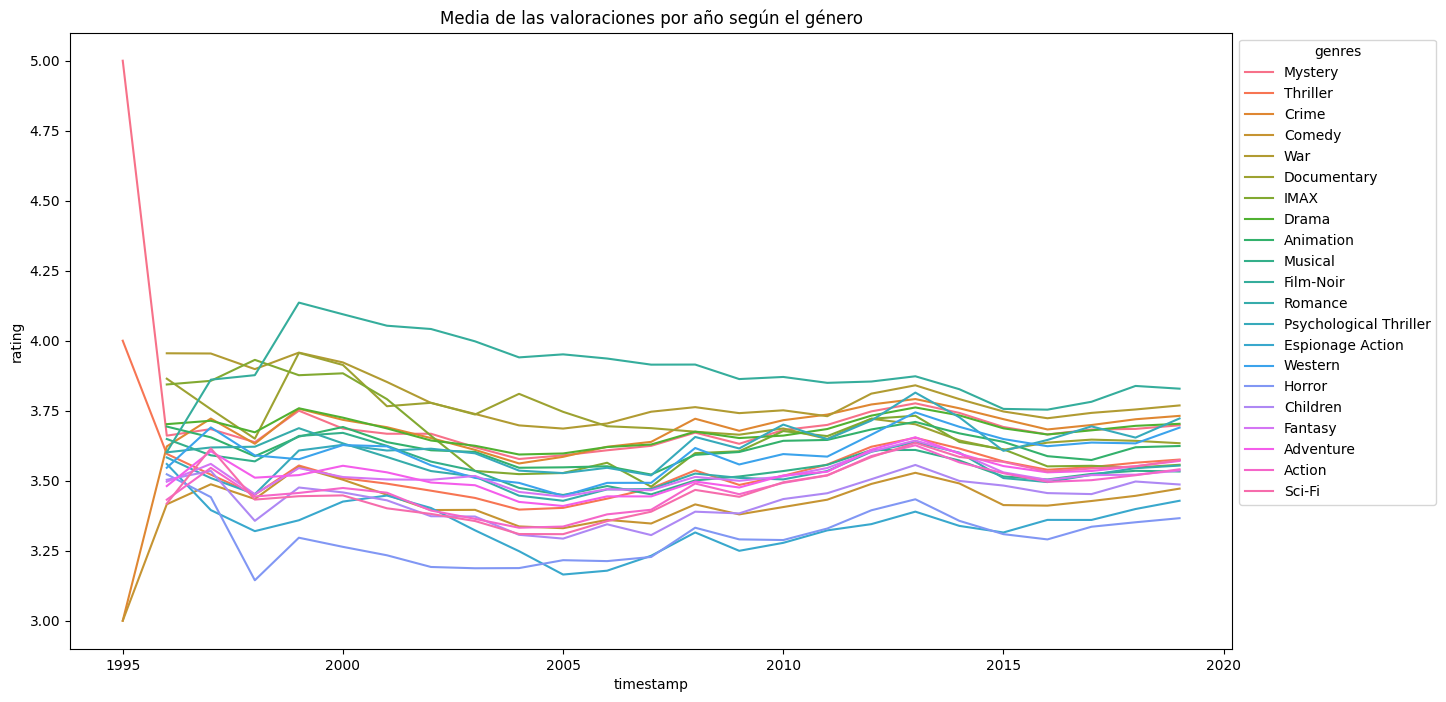

In [81]:
plt.figure(figsize=(15,8))
g = sns.lineplot(data=year_genre, x = 'timestamp', y = 'rating', hue = 'genres');
g.set(title = "Media de las valoraciones por año según el género");
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

Presentamos la tabla con todos los valores ordenados adecuadamente:

In [82]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(year_genre.sort_values(by = ['genres', 'timestamp'],ascending=[True, True]).set_index(['timestamp', 'genres']).swaplevel())

                                  rating
genres                 timestamp        
Action                 1996        3.432
                       1997        3.546
                       1998        3.444
                       1999        3.456
                       2000        3.474
                       2001        3.457
                       2002        3.393
                       2003        3.364
                       2004        3.332
                       2005        3.336
                       2006        3.380
                       2007        3.396
                       2008        3.490
                       2009        3.452
                       2010        3.492
                       2011        3.519
                       2012        3.588
                       2013        3.627
                       2014        3.566
                       2015        3.527
                       2016        3.496
                       2017        3.502
                

Este conjunto posee los mismos sesgos que el anterior, las valoraciones entre 0 y 10 y la falta de géneros en más del 8% de las películas de la lista.